# Sections 

- **Section 1:**

        Data Reading and Cleaning 

- **Section 2:**

        Data Exploration

- **Section 3:**

        Classical Learning modelling and Tuning

- **Section 4:**

        Deep Learning modelling and Tuning



Mandatory Imports

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Section 1

# Read initial data and analyse the text file
Let's load our dataset, examine rudimentary attributes, and fix any issues.

In [4]:
data = pd.read_csv('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None,sep=",")
data.columns = ['id', 'class', 'timestamp', 'x', 'y', 'z']

In [5]:
data = data.sort_values(['id', 'timestamp'])
data.head()

,id,class,timestamp,x,y,z
941965,1,Walking,4991922345000,0.69,10.80,-2.03
941966,1,Walking,4991972333000,6.85,7.44,-0.50
941967,1,Walking,4992022351000,0.93,5.63,-0.50
941968,1,Walking,4992072339000,-2.11,5.01,-0.69
941969,1,Walking,4992122358000,-4.59,4.29,-1.95


In [6]:
data.columns

Index(['id', 'class', 'timestamp', 'x', 'y', 'z'], dtype='object')

In [7]:
data.head()

,id,class,timestamp,x,y,z
941965,1,Walking,4991922345000,0.69,10.80,-2.03
941966,1,Walking,4991972333000,6.85,7.44,-0.50
941967,1,Walking,4992022351000,0.93,5.63,-0.50
941968,1,Walking,4992072339000,-2.11,5.01,-0.69
941969,1,Walking,4992122358000,-4.59,4.29,-1.95


In [8]:
for i in data.columns:
    print(i,data[i][pd.to_numeric(data[i],errors='coerce').isnull()].nunique())

id 0
class 6
timestamp 0
x 0
y 0
z 0


## Correct errors in data
There seems to be a missing number. Let's just drop that row.

In [9]:
data[pd.to_numeric(data['z'],errors='coerce').isnull()]

,id,class,timestamp,x,y,z
343419,11,Walking,1867172313000,4.4,4.4,NaN


In [10]:
idx = data[pd.to_numeric(data['z'],errors='coerce').isnull()].index
idx

Int64Index([343419], dtype='int64')

In [11]:
for x in idx:
    print(x)
    data.drop(x,axis=0,inplace=True)

343419


## Canonicalize data format
Ensure that the parsed data is consistent.

In [12]:
data[['timestamp','id']]=data[['timestamp','id']].astype(int)
data[[ 'x', 'y', 'z']]=data[[ 'x', 'y', 'z']].astype(float)
data[['class']]=data[['class']].astype(str)

In [13]:
data.dtypes

id             int64
class         object
timestamp      int64
x            float64
y            float64
z            float64
dtype: object

In [14]:
data.sort_values(['id','timestamp'],inplace=True)

In [15]:
data.reset_index(drop=True,inplace=True)

Pull out class domain for later use.

In [16]:
# classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
classes = list(data['class'].unique())

# Section 1

## Explore basic statistics on data

In [17]:
data.groupby('class').size()/data.shape[0]*100

class
Downstairs     9.144625
Jogging       31.157941
Sitting        5.457891
Standing       4.406724
Upstairs      11.188136
Walking       38.644683
dtype: float64

In [18]:
data[(data['id']==2)&(data['class']=='Walking')]['timestamp'].max()

10012532331000

In [19]:
data[(data['id']==2)&(data['timestamp']>=10012532331000)]

,id,class,timestamp,x,y,z
47245,2,Walking,10012532331000,-2.96,7.31,-4.40
47246,2,Jogging,10065442335000,-4.71,2.18,3.68
47247,2,Jogging,10065492322000,-9.89,6.89,2.68
47248,2,Jogging,10065542341000,-9.66,11.54,2.11
47249,2,Jogging,10065592328000,-8.08,9.28,4.52
...,...,...,...,...,...,...
53498,2,Jogging,10378042341000,-12.18,3.30,0.34
53499,2,Jogging,10378092298000,-11.03,3.26,-5.86
53500,2,Jogging,10378142347000,-10.34,7.50,-6.09
53501,2,Jogging,10378192335000,-8.35,5.48,-2.41


In [20]:
data.iloc[17855:17865]

,id,class,timestamp,x,y,z
17855,1,Walking,5974702314000,-2.87,6.55,-0.04
17856,1,Walking,5974702314000,-2.87,6.55,-0.04
17857,1,Walking,5974772290000,0.61,19.46,12.22
17858,1,Walking,5974822278000,-1.31,12.07,-0.46
17859,1,Walking,5974872327000,-1.18,12.95,1.18
17860,1,Jogging,5995682355000,10.04,5.67,1.76
17861,1,Jogging,5995732343000,5.28,8.35,1.31
17862,1,Jogging,5995782331000,6.59,9.28,5.52
17863,1,Jogging,5995832349000,3.72,7.35,5.28
17864,1,Jogging,5995882337000,10.53,10.99,3.30


In [21]:
data.describe()
# y axis has more IQR range more on the positive side, whereas x,z have distribution symmetrical to axis 

,id,timestamp,x,y,z
count,1.098208e+06,1.098208e+06,1.098208e+06,1.098208e+06,1.098208e+06
mean,1.886067e+01,3.340895e+13,6.628660e-01,7.255626e+00,4.110784e-01
std,1.021423e+01,4.944962e+13,6.849046e+00,6.746216e+00,4.754120e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,2.019110e+12,-2.870000e+00,3.170000e+00,-2.220000e+00
50%,1.900000e+01,9.722677e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,4.996560e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


In [23]:
# data.groupby('id')['timestamp'].shift(periods=1).diff()

In [24]:
(data[:200].timestamp.max()-data[:200].timestamp.min())

9950013000

## Visualize raw data

**Exploring data across different axis - vs different classes**

We can see an obvious difference between variations when a person is walking vs jogging vs sitting

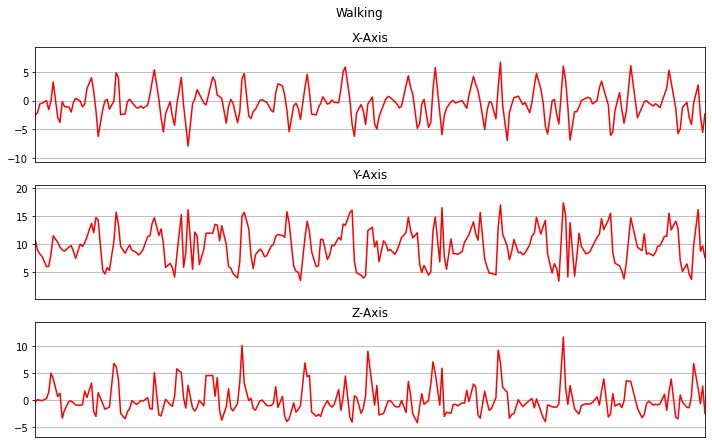

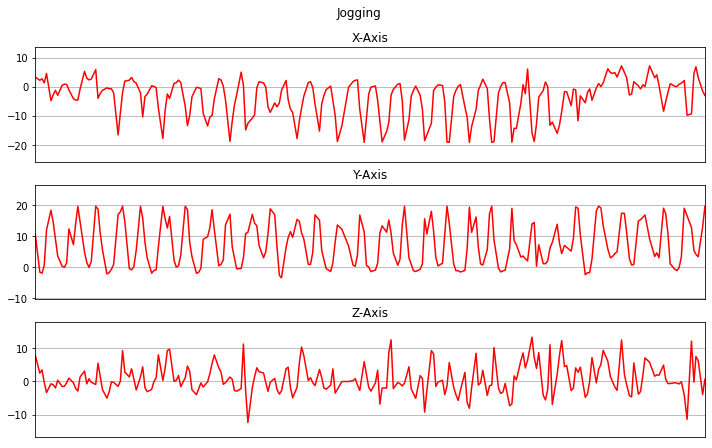

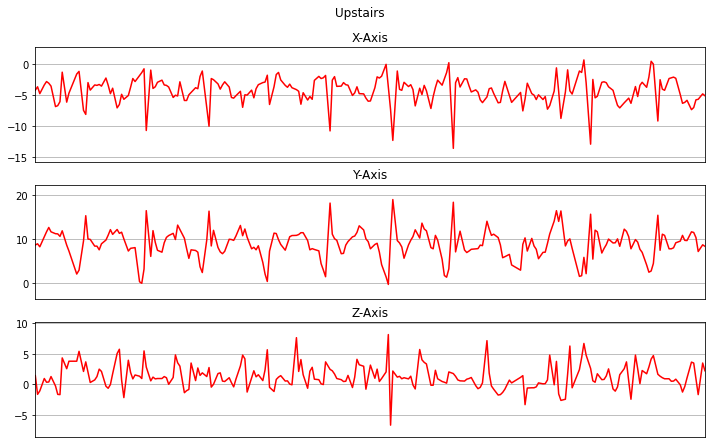

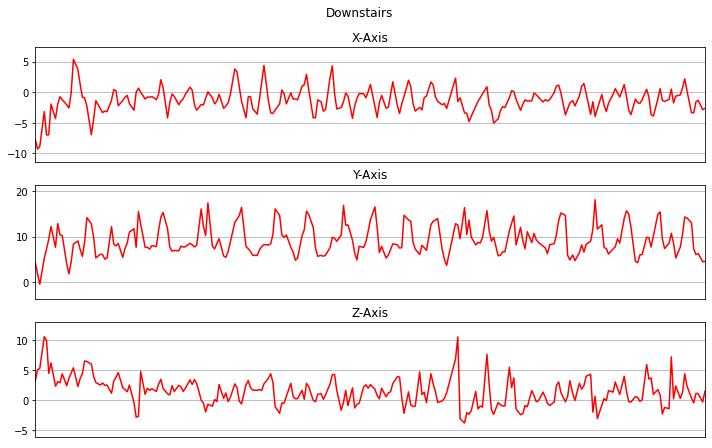

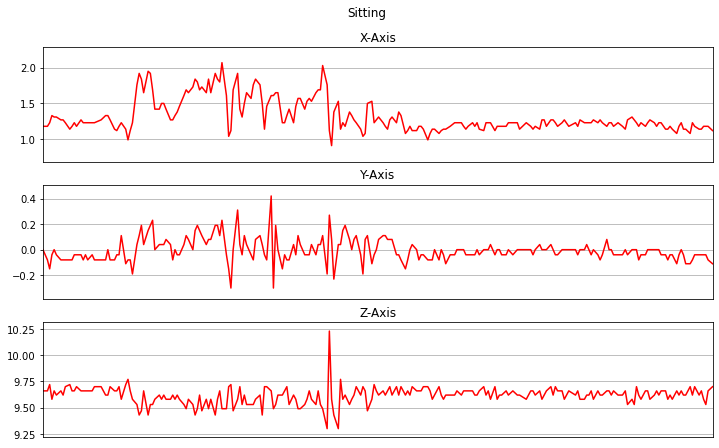

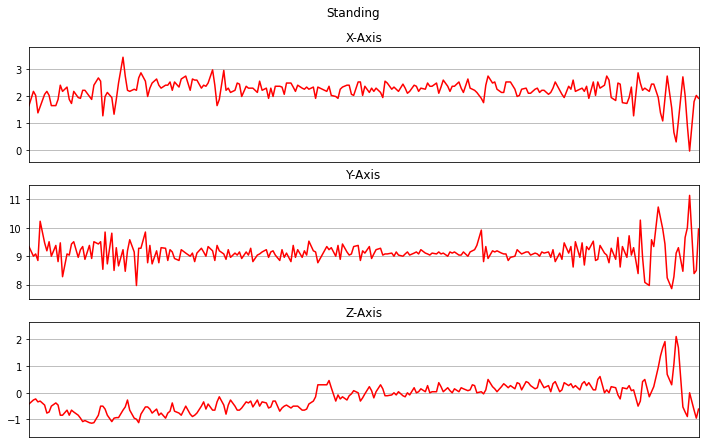

In [31]:
seconds = 20
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 7))
    plot_axis(ax0, data['timestamp'], data['x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
for c in classes:
    plot_activity(c, data[(data['id']==31)&(data['class'] == c)][:seconds*12])

Checking statistics for each axis -> we can see that the values vary too much hence we might need normalisation 

In [32]:
data.groupby('class')['x'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
Downstairs,100427.0,0.471718,4.955948,-19.61,-2.18,0.08,2.83,19.95
Jogging,342179.0,-0.201963,9.109470,-19.61,-5.43,0.00,5.18,19.95
Sitting,59939.0,1.856270,4.759028,-10.31,-1.61,1.53,5.75,12.45
Standing,48395.0,-1.178258,3.235125,-10.99,-2.03,-1.12,0.61,13.10
Upstairs,122869.0,0.381334,5.495272,-19.61,-2.26,0.15,3.06,19.95
Walking,424399.0,1.528288,5.793331,-19.61,-2.15,0.95,4.82,19.91


In [33]:
data.groupby('class')['y'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
Downstairs,100427.0,8.600230,4.904716,-19.61,5.94,8.58,11.45,20.04
Jogging,342179.0,5.461080,9.224947,-19.61,-0.72,4.56,13.38,20.04
Sitting,59939.0,1.853374,3.257750,-9.30,-0.95,2.49,3.72,18.47
Standing,48395.0,8.987236,1.264772,-0.65,8.50,9.43,9.81,19.46
Upstairs,122869.0,8.111545,4.890709,-19.61,5.43,8.54,11.03,20.04
Walking,424399.0,8.702048,5.006519,-18.85,5.28,8.77,12.15,20.04


In [34]:
data.groupby('class')['z'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
Downstairs,100427.0,0.684080,3.706798,-19.61,-1.438689,0.503953,2.750000,19.34
Jogging,342179.0,-0.124295,5.833195,-19.80,-3.490000,-0.299648,3.296124,19.61
Sitting,59939.0,6.559716,3.735591,-10.80,5.710000,8.117727,8.920000,13.99
Standing,48395.0,0.580193,1.376870,-4.14,-0.500000,0.650000,1.420000,7.25
Upstairs,122869.0,0.323542,3.567884,-19.61,-1.688923,0.081722,2.070293,19.19
Walking,424399.0,-0.084199,4.011106,-19.38,-2.370000,-0.503953,1.690000,19.23


In [36]:
data.head()

,id,class,timestamp,x,y,z
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


# Base Learning Models
Here we define our two base methods for classification: A vanilla decision tree
as well as a simple logistic regression classifier. Later on, we will cover
more advanced models, but these two will suffice for setting a baseline
expectation and for exploring feature generation.

In [332]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score

In [18]:
def generate_all_stats(y_train,train_pred,y_test,test_pred):
    frame = pd.DataFrame({
        'train': [accuracy_score(train_pred, y_train), 
                  f1_score(train_pred, y_train, average="weighted"),
                  precision_score(train_pred,y_train,average='weighted',zero_division= 0),
                  recall_score(train_pred,y_train,average='weighted',zero_division= 0),
                 ],
        'test': [accuracy_score(test_pred, y_test), 
                 f1_score(test_pred, y_test, average='weighted'),
                 precision_score(test_pred,y_test,average='weighted',zero_division= 0),
                 recall_score(test_pred,y_test,average='weighted',zero_division= 0),   
                ],
    })

    frame.index = ['Accuracy', 'F1','Precision','Recall']
    return frame

def generate_per_class_stats(y_train,train_pred,y_test,test_pred):
    classMap = {}
    for c in classes:
        classMap[c] = [
        accuracy_score(train_pred[np.array(y_train)==c],y_train[np.array(y_train)==c]),
        f1_score(train_pred[np.array(y_train)==c],y_train[np.array(y_train)==c],average='weighted',zero_division= 0),
        precision_score(train_pred[np.array(y_train)==c],y_train[np.array(y_train)==c],average='weighted',zero_division= 0),
        recall_score(train_pred[np.array(y_train)==c],y_train[np.array(y_train)==c],average='weighted',zero_division= 0),
        accuracy_score(test_pred[np.array(y_test)==c],y_test[np.array(y_test)==c]),
        f1_score(test_pred[np.array(y_test)==c],y_test[np.array(y_test)==c],average='weighted',zero_division= 0),
        precision_score(test_pred[np.array(y_test)==c],y_test[np.array(y_test)==c],average='weighted',zero_division= 0),
        recall_score(test_pred[np.array(y_test)==c],y_test[np.array(y_test)==c],average='weighted',zero_division= 0),     
        ]
    frame = pd.DataFrame(classMap)
    frame.index = ['Acc (train)', 'F1 (train)', 'Prec (train)', 'Recall (train)', 'Acc (test)', 'F1 (test)', 'Prec (test)', 'Recall (test)']
    return frame

def evaluate_with_features(f_data, features, class_label='class', skip_log=False):
    train, test, y_train, y_test = train_test_split(f_data[features], f_data[class_label], stratify=f_data[class_label])
    dt = tree.DecisionTreeClassifier()
    dt.fit(train, y_train)
    train_pred = dt.predict(train)
    test_pred = dt.predict(test)

    frame1 = generate_all_stats(y_train,train_pred,y_test,test_pred)
    frame2 = generate_per_class_stats(y_train,train_pred,y_test,test_pred)

    if skip_log:
        return frame1, frame2

    clf = LogisticRegression(solver='saga')
    clf.fit(train, y_train)
    train_pred = clf.predict(train)
    test_pred = clf.predict(test)    

    frame3 = generate_all_stats(y_train,train_pred,y_test,test_pred)
    frame4 = generate_per_class_stats(y_train,train_pred,y_test,test_pred)

    return frame1, frame2, frame3, frame4

In [19]:
# Uncomment to export data.
# data[['id', 'class', 'timestamp', 'x', 'y', 'z']].to_csv('./preProcessed_data.csv',index=False)

## Examine base model performance on raw data
Now that we have our models, lets examine they work on the unprocessed x,y,z
accelerometer values!

In [129]:
dt_all, dt_class, log_all, log_class = evaluate_with_features(data, ['x', 'y', 'z'], class_label='class')

In [130]:
# Decision tree stats
dt_all

,train,test
Accuracy,0.997703,0.543813
F1,0.997703,0.542491
Precision,0.997708,0.541376
Recall,0.997703,0.543813


In [131]:
# Decision tree stats by class
dt_class

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.996387,0.999821,0.995301,0.997451,0.999822,0.998264
F1 (train),0.994584,0.999731,0.992957,0.996178,0.999733,0.997397
Prec (train),0.992787,0.999642,0.990625,0.994908,0.999644,0.996532
Recall (train),0.996387,0.999821,0.995301,0.997451,0.999822,0.998264
Acc (test),0.555118,0.636024,0.222059,0.196519,0.970437,0.801884
F1 (test),0.396312,0.494523,0.080700,0.064553,0.955877,0.713718
Prec (test),0.308156,0.404526,0.049310,0.038620,0.941748,0.643019
Recall (test),0.555118,0.636024,0.222059,0.196519,0.970437,0.801884


Hmm, the high training but low test accuracy suggests overfitting. Let's try
some regularization?

In [134]:
train, test, y_train, y_test = train_test_split(data[['x','y','z']], data['class'], stratify=data['class'])

frames = []
depths = []

for depth in range(4, 24,2):
    print(f'depth: {depth}')
    dt = tree.DecisionTreeClassifier(max_depth=depth)
    dt.fit(train, y_train)
    train_pred = dt.predict(train)
    test_pred = dt.predict(test)
    frame1 = generate_all_stats(y_train,train_pred,y_test,test_pred)
    frame2 = generate_per_class_stats(y_train,train_pred,y_test,test_pred)
    frames.append((frame1, frame2))
    depths.append(depth*2)


fig = plt.figure(figsize = (10, 5))
 
bar = plt.bar(depths, list(map(lambda v: v[0]['test'][0], frames)), color ='red', width = 0.6)
plt.bar_label(bar, padding=3)
 
plt.xlabel("Depth")
plt.ylabel("Test accuracy")
plt.title("Decision Tree Accuracy by depth limit")
plt.show()


depth: 4
depth: 6
depth: 8
depth: 10
depth: 12


KeyboardInterrupt: 

So it seems to peak at about 0.63 accuracy. Not terrible for a naive baseline.

Now what about logistic regression?

In [132]:
log_all

,train,test
Accuracy,0.476663,0.476431
F1,0.551819,0.551652
Precision,0.690597,0.690482
Recall,0.476663,0.476431


In [133]:
log_class 

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.807822,0.454813,0.0,0.0,0.417226,0.0
F1 (train),0.721948,0.284373,0.0,0.0,0.245660,0.0
Prec (train),0.652577,0.206855,0.0,0.0,0.174078,0.0
Recall (train),0.807822,0.454813,0.0,0.0,0.417226,0.0
Acc (test),0.808313,0.453673,0.0,0.0,0.416016,0.0
F1 (test),0.722629,0.283171,0.0,0.0,0.244445,0.0
Prec (test),0.653370,0.205819,0.0,0.0,0.173069,0.0
Recall (test),0.808313,0.453673,0.0,0.0,0.416016,0.0


We can consider logistic as our baseline since it has Regularisation (penalty) inherently there, we will train and tune our Decision tree later

## Baseline 
**Accuracy:** 0.47  
**F1:**	0.551819


## Examine Axis Normalization via PCA
Phones aren't strictly guaranteed to have the same real-world orientation, so
let's examine projecting x,y,z onto the high-variance vector components.

In [45]:
from sklearn.decomposition import PCA

# Should be 3D...
def generatePCA2D(X,person='all'):
    pca = PCA(n_components=3)
    pca.fit(X)

    m = X.mean()
    t_mean = [m['x'], m['y']]
    components = pca.components_
    print(components)
    values = pca.singular_values_ / 10
    plt.title('Person ID: ' + person)
    plt.axis('equal')
    plt.arrow(t_mean[0], t_mean[1], components[0, 0]*values[0], components[1, 0]*values[0], ec='red', head_width=0.1)
    plt.arrow(t_mean[0], t_mean[1], components[0, 1]*values[1], components[1, 1]*values[1], ec='green', head_width=0.1)
    #plt.scatter(X['x'], X['y'], s=10)
    plt.show()


[[-0.86712998 -0.49030744 -0.08765961]
 [ 0.4898669  -0.8713489   0.02795562]
 [ 0.09008895  0.01870039 -0.99575814]]


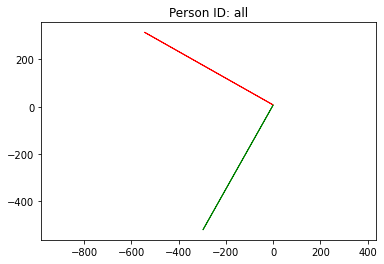

In [46]:
generatePCA2D(train)

[[-0.87385356 -0.48529606  0.0294565 ]
 [ 0.48557526 -0.86810297  0.10302378]
 [-0.02442576  0.10433105  0.99424263]]


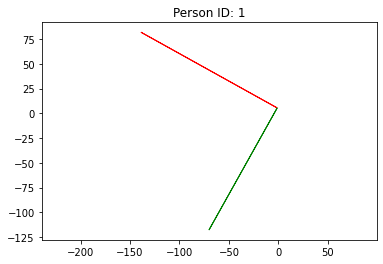

[[ 0.89118323 -0.32302165  0.31851132]
 [-0.20529491 -0.91328275 -0.35180766]
 [-0.40453238 -0.24813633  0.88021697]]


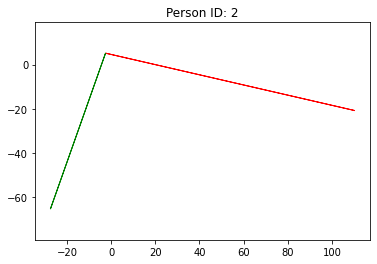

[[ 0.86269179  0.47083738  0.18459423]
 [-0.50425433  0.82869071  0.24289766]
 [ 0.03860622  0.30262826 -0.95232646]]


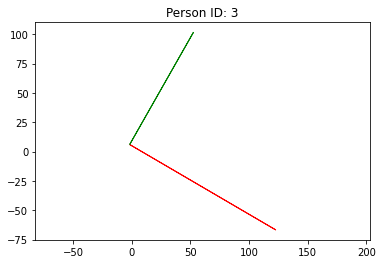

[[-0.69796483 -0.65086313 -0.29870101]
 [ 0.51363532 -0.74562997  0.42451703]
 [ 0.49902291 -0.14287457 -0.85472978]]


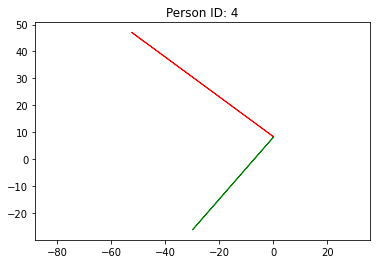

[[-0.26914381 -0.90989394 -0.31568121]
 [-0.70957201  0.40896714 -0.5738061 ]
 [ 0.65120593  0.06956219 -0.75570625]]


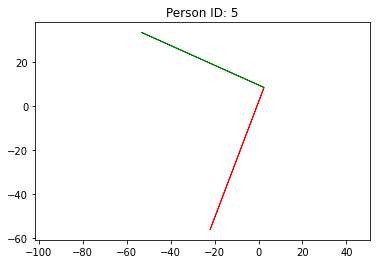

[[-0.72642321  0.62360641 -0.28883275]
 [-0.66070141 -0.74937309  0.04374497]
 [-0.18916385  0.22260957  0.95637964]]


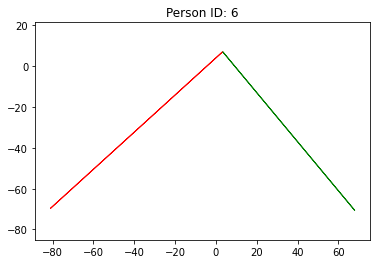

[[-0.99962158  0.02693648  0.00557877]
 [-0.02493808 -0.97299055  0.22949396]
 [-0.01160985 -0.22926799 -0.9732941 ]]


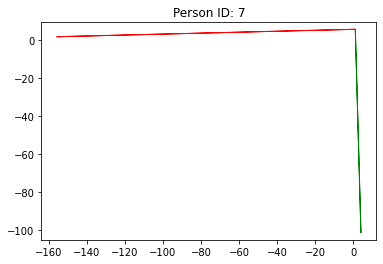

In [47]:
for p in range(1, 8):
    data2 = data[data['id'] == p][['x', 'y', 'z']]
    generatePCA2D(data2, str(p))

In [48]:
projData = pd.read_csv('./preProcessed_data.csv')
unflat = []
unflat_y = []
for p in projData.groupby('id'):
    id = p[0]
    pData = p[1][['x', 'y', 'z']]
    ys = list(p[1]['class'])
    pca = PCA(n_components=3)
    pca.fit(pData)
    new = pca.transform(pData)
    projData.loc[projData['id'] == id,['x', 'y', 'z']] = new
    unflat.append(new)
    unflat_y.append(ys)
print(projData)
print(unflat[0])

         id     class       timestamp         x         y         z
0         1   Walking   4991922345000 -4.343887 -3.881268 -1.917725
1         1   Walking   4991972333000 -8.051162  2.184328 -0.897549
2         1   Walking   4992022351000 -1.999563  0.880989 -0.941788
3         1   Walking   4992072339000  0.952238 -0.076510 -1.121125
4         1   Walking   4992122358000  3.431693 -0.785513 -2.388413
...      ..       ...             ...       ...       ...       ...
1098203  36  Standing  15049012250000 -1.237539 -0.125010  1.254719
1098204  36  Standing  15049062268000 -1.328165 -0.021741  1.005537
1098205  36  Standing  15049112287000 -1.363376  0.180052  0.755518
1098206  36  Standing  15049162275000 -0.619533  0.214199  0.067448
1098207  36  Standing  15049212262000 -1.771388  1.112551  0.599694

[1098208 rows x 6 columns]
[[-4.34388748 -3.88126753 -1.91772541]
 [-8.05116221  2.18432844 -0.89754918]
 [-1.99956325  0.88098927 -0.94178789]
 ...
 [-8.63276244  4.73598951 -1.82865

In [49]:
rows = []
y_vals = []
for mat, ys in zip(unflat, unflat_y):
    for row, y in zip(mat, ys):
        rows.append(row)
        y_vals.append(y)


projected_X = np.array(rows)
projected_Y = np.array(y_vals)

In [50]:
# proj_train, proj_test, proj_y_train, proj_y_test = train_test_split(projected_X, projected_Y,)
# clf = LogisticRegression(solver='liblinear')
# clf.fit(proj_train, proj_y_train)
# print(f'Logistic regression training accuracy: {accuracy_score(clf.predict(proj_train), proj_y_train)}.')
# print(f'Logistic regression test accuracy: {accuracy_score(clf.predict(proj_test), proj_y_test)}.')

In [51]:
# dt = tree.DecisionTreeClassifier()
# dt.fit(proj_train, proj_y_train)
# accuracy_score(dt.predict(proj_test),proj_y_test)

In [52]:
# projDataTotal = pd.read_csv('./preProcessed_data.csv')
# x_num, y_num = projDataTotal[['x', 'y', 'z']], projDataTotal['class']
# pca = PCA(n_components=3)
# pca.fit(x_num)
# x_num_proj = pca.transform(x_num)

# projDataTotal.loc[:, ['x', 'y,', 'z']] = x_num_proj

# proj_train, proj_test, proj_y_train, proj_y_test = train_test_split(x_num_proj, y_num,)
# clf = LogisticRegression(solver='liblinear')
# clf.fit(proj_train, proj_y_train)
# print(f'Logistic regression training accuracy: {accuracy_score(clf.predict(proj_train), proj_y_train)}.')
# print(f'Logistic regression test accuracy: {accuracy_score(clf.predict(proj_test), proj_y_test)}.')

# dt = tree.DecisionTreeClassifier()
# dt.fit(proj_train, proj_y_train)
# accuracy_score(dt.predict(proj_test),proj_y_test)

In [53]:
# x_num_proj = np.random.rand(y_num.shape[0], 3)
# proj_train, proj_test, proj_y_train, proj_y_test = train_test_split(x_num_proj, y_num,)
# clf = LogisticRegression(solver='liblinear')
# clf.fit(proj_train, proj_y_train)
# print(f'Logistic regression training accuracy: {accuracy_score(clf.predict(proj_train), proj_y_train)}.')
# print(f'Logistic regression test accuracy: {accuracy_score(clf.predict(proj_test), proj_y_test)}.')

The results did not show much significance

# Features
Since performance using raw x,y,z acceleration data is not very informative,
here we generate aggregate features over rolling/sliding windows.

In [135]:
# Our base data under consideration.
data = pd.read_csv('./preProcessed_data.csv')

# Can override to some other data, like the PCA-projected above.
# Consider ProjData?
# data = projData

In [136]:
data.columns

Index(['id', 'class', 'timestamp', 'x', 'y', 'z'], dtype='object')

*Sampling rate*

20Hz (1 sample every 50ms)

*  5 sec - 100 records
* 10 sec - 200 records
* 15 sec - 300 records 
* 20 sec - 400 records

## Calculate rolling window features

In [140]:
# Window width
w = 200

# Sliding window 'stride'
stride = 4 * 20

# Minimum observations needed in a window for the data point to count.
min_periods = 5

# If true, the window is centered around the given point. If false, the right
# edge of the window is used.
center = False

In [20]:
def add_rolling_metrics(data, w, min_periods, center):
    rolling_data_x = data.groupby('id')['x'].rolling(window=w, min_periods=min_periods, center=center)
    rolling_data_y = data.groupby('id')['y'].rolling(window=w, min_periods=min_periods, center=center)
    rolling_data_z = data.groupby('id')['z'].rolling(window=w, min_periods=min_periods, center=center)

    data['rolling_x_mean'] = list(rolling_data_x.mean().fillna(0))
    data['rolling_y_mean'] = list(rolling_data_y.mean().fillna(0))
    data['rolling_z_mean'] = list(rolling_data_z.mean().fillna(0))

    data['rolling_x_std'] = list(rolling_data_x.std().fillna(0))
    data['rolling_y_std'] = list(rolling_data_y.std().fillna(0))
    data['rolling_z_std'] = list(rolling_data_z.std().fillna(0))

    data['rolling_x_min'] = list(rolling_data_x.min().fillna(0))
    data['rolling_y_min'] = list(rolling_data_y.min().fillna(0))
    data['rolling_z_min'] = list(rolling_data_z.min().fillna(0))

    data['rolling_x_max'] = list(rolling_data_x.max().fillna(0))
    data['rolling_y_max'] = list(rolling_data_y.max().fillna(0))
    data['rolling_z_max'] = list(rolling_data_z.max().fillna(0))

    data['rolling_x_iqr'] = np.array(rolling_data_x.quantile(0.75).fillna(0))-np.array(rolling_data_x.quantile(0.25).fillna(0))
    data['rolling_y_iqr'] = np.array(rolling_data_y.quantile(0.75).fillna(0))-np.array(rolling_data_y.quantile(0.25).fillna(0))
    data['rolling_z_iqr'] = np.array(rolling_data_z.quantile(0.75).fillna(0))-np.array(rolling_data_z.quantile(0.25).fillna(0))

    data['avg_speed'] = np.sqrt(np.square(data['x'])+np.square(data['y'])+np.square(data['z']))
    data['rolling_mean_speed'] = list(data.groupby('id')['avg_speed'].rolling(window=w,min_periods=5).mean().fillna(0))

    data['abs_x_diff'] = np.abs(data.groupby('id')['x'].diff().fillna(0))
    data['abs_y_diff'] = np.abs(data.groupby('id')['y'].diff().fillna(0))
    data['abs_z_diff'] = np.abs(data.groupby('id')['z'].diff().fillna(0))

    data['rolling_abs_x_diff'] = list(data.groupby('id')['abs_x_diff'].rolling(window=w,min_periods=5).mean().fillna(0))
    data['rolling_abs_y_diff'] = list(data.groupby('id')['abs_y_diff'].rolling(window=w,min_periods=5).mean().fillna(0))
    data['rolling_abs_z_diff'] = list(data.groupby('id')['abs_z_diff'].rolling(window=w,min_periods=5).mean().fillna(0))

In [142]:
add_rolling_metrics(data, w, min_periods, False)

In [143]:
data.head()

,id,class,timestamp,x,y,z,rolling_x_mean,rolling_y_mean,rolling_z_mean,rolling_x_std,...,rolling_y_iqr,rolling_z_iqr,avg_speed,rolling_mean_speed,abs_x_diff,abs_y_diff,abs_z_diff,rolling_abs_x_diff,rolling_abs_y_diff,rolling_abs_z_diff
0,1,Walking,4991922345000,0.69,10.80,-2.03,0.000,0.000,0.000,0.000000,...,0.00,0.00,11.010767,0.00000,0.00,0.00,0.00,0.00,0.000,0.000
1,1,Walking,4991972333000,6.85,7.44,-0.50,0.000,0.000,0.000,0.000000,...,0.00,0.00,10.125517,0.00000,6.16,3.36,1.53,0.00,0.000,0.000
2,1,Walking,4992022351000,0.93,5.63,-0.50,0.000,0.000,0.000,0.000000,...,0.00,0.00,5.728159,0.00000,5.92,1.81,0.00,0.00,0.000,0.000
3,1,Walking,4992072339000,-2.11,5.01,-0.69,0.000,0.000,0.000,0.000000,...,0.00,0.00,5.479808,0.00000,3.04,0.62,0.19,0.00,0.000,0.000
4,1,Walking,4992122358000,-4.59,4.29,-1.95,0.354,6.634,-1.134,4.276597,...,2.43,1.45,6.578351,7.78452,2.48,0.72,1.26,3.52,1.302,0.596


### Calculate R2 coefficient per window
For each window, fit a linear regression line, and then aggregate to R2 value.
Note that the window anchor may be different than the above since Pandas made
multiple columns hard.

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def fitR2(x, y, z):
    d = np.array([x, y]).T
    reg = LinearRegression().fit(d, z)
    z_pred = reg.predict(d)
    return r2_score(z, z_pred)

def fitR21D(y):
    x = np.array(list(range(y.size))).reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    y_pred = reg.predict(x)
    return r2_score(y, y_pred)

# Load data from CSV since initial calulation took 9 minutes on my machine!
rolling_data_r2 = pd.read_csv('./window_200_r2fit.csv')
data['rolling_data_r2'] = rolling_data_r2

# Use a different rolling window method since pandas made it really hard/slow
# to do rolling window calculations over multiple columns.
# from numpy_ext import rolling_apply
# rolling_data_r2 = rolling_apply(fitR2, w, data.x.values, data.y.values, data.z.values, n_jobs=4)

data['rolling_x_r2'] = pd.read_csv('./r2x.csv')
data['rolling_y_r2'] = pd.read_csv('./r2y.csv')
data['rolling_z_r2'] = pd.read_csv('./r2z.csv')

In [60]:
# ONLY run this cell when we need to regenerate data!
# This took nearly 30 minutes on my machine so I'd avoid it unless needed.

# data['rolling_x_r2']=list(rolling_data_x.apply(fitR21D, raw=True).fillna(0))
# data['rolling_y_r2']=list(rolling_data_y.apply(fitR21D, raw=True).fillna(0))
# data['rolling_z_r2']=list(rolling_data_z.apply(fitR21D, raw=True).fillna(0))

# data['rolling_x_r2'].to_csv('./r2x.csv',index=False)
# data['rolling_y_r2'].to_csv('./r2y.csv',index=False)
# data['rolling_z_r2'].to_csv('./r2z.csv',index=False)

### Change class to modal window class
Currently, the 'class' representing each window sample is just the class taken
from the anchor of the window. Here, we generate a new feature 'class_mode'
that is equal to the most common class in that window.

In [153]:
import statistics
data['classId'] = data['class'].map(classes.index) 

class_window = data.groupby('id')['classId'].rolling(window=w, min_periods=5, center=False)
data['class_mode_id'] = list(class_window.apply(statistics.mode, raw=True).fillna(0))
data['class_mode'] = data['class_mode_id'].map(lambda x: classes[int(x)])
data.drop(columns=['classId', 'class_mode_id'], inplace=True)

* Window width
w = 200

* Sliding window 'stride'
stride = 4 * 20


### Subset Data - consider every 4th second
Apply the configured stride to our data.

In [21]:
def subsample_data(data, stride, window_width):
    final = pd.DataFrame()
    for key, dat in data.groupby('id'):
        dat.reset_index(drop=True, inplace=True)
        final = final.append(dat.iloc[list(range(window_width, len(dat) - window_width, stride))])  
    return final


In [161]:
final = subsample_data(data, stride, w)

In [164]:
final['class'].value_counts()

Walking       5258
Jogging       4244
Upstairs      1510
Downstairs    1241
Sitting        740
Standing       572
Name: class, dtype: int64

### Plot Features vs Time/Index

In [165]:
features = [
    'x', 'y', 'z', 'rolling_x_mean',
    'rolling_y_mean', 'rolling_z_mean', 'rolling_x_std', 'rolling_y_std',
    'rolling_z_std', 'rolling_x_min', 'rolling_y_min', 'rolling_z_min',
    'rolling_x_max', 'rolling_y_max', 'rolling_z_max', 'rolling_x_iqr',
    'rolling_y_iqr', 'rolling_z_iqr',  'rolling_mean_speed', 
    'rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff',
    'rolling_x_r2', 'rolling_y_r2', 'rolling_z_r2'
]

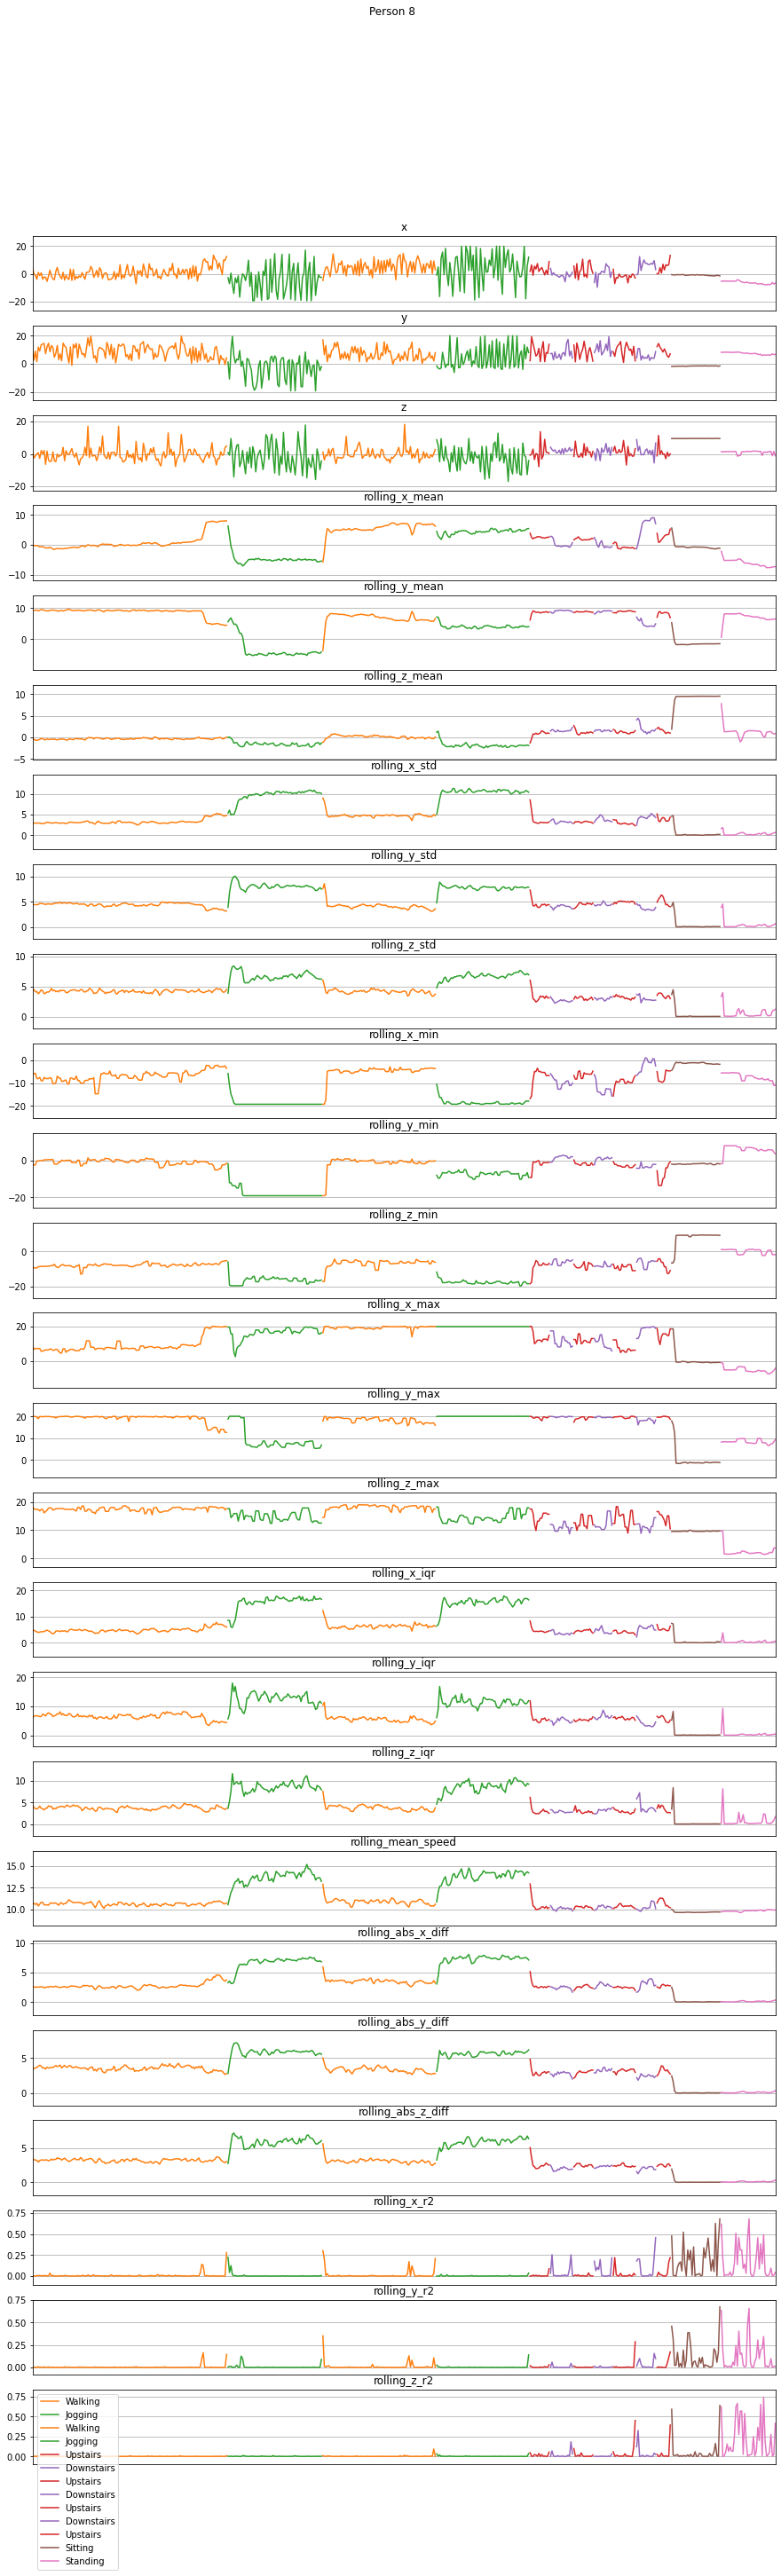

In [171]:
timeSteps = 100
def plot_activity2(activity, data):
    fig, axTup = plt.subplots(nrows=len(features), figsize=(15, 45))
    for ax, feat in zip(axTup, features):
        # Note that I'm using range() vs timestamp
        plot_axis2(ax, range(len(data)), data[feat], data['class'], feat)
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.legend()
    plt.show()

def classColor(c):
    if c == 'Walking':
        return "C1"
    elif c == 'Jogging':
        return "C2"
    elif c == 'Upstairs':
        return "C3"
    elif c == 'Downstairs':
        return "C4"
    elif c == 'Sitting':
        return "C5"
    elif c == 'Standing':
        return "C6"
    
    raise Exception('Invalid class: ' + c)

# Split x,y graph values into contiguous sublists
# based on activity.
def splitByActivity(X, Y, C):
    lastC = None
    cumXY = []
    cumClass = []
    currXY = []
    currClass = []
    for x, y, c in zip(X, Y, C):
        if lastC is not None and lastC != c:
            cumXY.append(currXY)
            currXY = []
            cumClass.append(currClass)
            currClass = []
        currXY.append([x, y])
        currClass.append(c)
        lastC = c
    if len(currXY) > 0:
        cumXY.append(currXY)
        cumClass.append(currClass)
    return cumXY, cumClass
        

def plot_axis2(ax, x, y, c, title):
    gxy, gc = splitByActivity(x, y, c)
    for xy, cc in zip(gxy, gc):
        ax.plot(list(map(lambda v: v[0], xy)), list(map(lambda v: v[1], xy)), classColor(cc[0]), label=cc[0])
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    


person = 8
plot_activity2('Person ' + str(person), final[(final['id'] == person)])

**How do the features perform on our baseline models?**

In [227]:
class_label = 'class_mode'

In [221]:
features = ['x', 'y', 'z', 'rolling_x_mean',
       'rolling_y_mean', 'rolling_z_mean', 'rolling_x_std', 'rolling_y_std',
       'rolling_z_std', 'rolling_x_min', 'rolling_y_min', 'rolling_z_min',
       'rolling_x_max', 'rolling_y_max', 'rolling_z_max', 'rolling_x_iqr',
       'rolling_y_iqr', 'rolling_z_iqr', 'avg_speed', 'rolling_mean_speed',
       'abs_x_diff', 'abs_y_diff', 'abs_z_diff', 'rolling_abs_x_diff',
       'rolling_abs_y_diff', 'rolling_abs_z_diff', 'rolling_x_r2',
       'rolling_y_r2', 'rolling_z_r2']

In [223]:
dt_all, dt_class, log_all, log_class = evaluate_with_features(final, features, class_label=class_label)

/Users/smrutichourasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [225]:
dt_all

,train,test
Accuracy,0.999803,0.898290
F1,0.999803,0.898892
Precision,0.999804,0.899661
Recall,0.999803,0.898290


In [224]:
log_all

,train,test
Accuracy,0.872506,0.868514
F1,0.878845,0.875317
Precision,0.889488,0.887628
Recall,0.872506,0.868514


In [228]:
log_class

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.947888,0.973668,0.597561,0.469747,0.927405,0.945498
F1 (train),0.922529,0.960677,0.447030,0.300272,0.892474,0.919010
Prec (train),0.898491,0.948029,0.357079,0.220662,0.860080,0.893966
Recall (train),0.947888,0.973668,0.597561,0.469747,0.927405,0.945498
Acc (test),0.953718,0.970865,0.586387,0.468647,0.875000,0.914894
F1 (test),0.931125,0.956512,0.433501,0.299091,0.816667,0.874232
Prec (test),0.909578,0.942578,0.343850,0.219630,0.765625,0.837030
Recall (test),0.953718,0.970865,0.586387,0.468647,0.875000,0.914894


As can be seen there is a drastic improvement - we weren't able to predict classes like Downstairs - Upstairs which now are being predicted with some accuracy and precision

## Benchmark:

* **Accuracy:**	0.868514
* **F1:**	0.875317

### Let's Tune Decision tree for further exploration 

In [229]:
from sklearn.model_selection import GridSearchCV
import sklearn

In [231]:
train, test, y_train, y_test = train_test_split(final[features], final[class_label], stratify=final[class_label])

In [240]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': np.linspace(4,20,2),
    'min_samples_leaf': [2, 5,20,50,100], 
    'criterion': ["gini", "entropy"],
    'random_state':[42],
    'class_weight':["balanced"], 
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "f1_weighted")

In [241]:
# sklearn.metrics.SCORERS.keys()

In [242]:
grid_search.fit(train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 4., 20.]),
                         'min_samples_leaf': [2, 5, 20, 50, 100],
                         'random_state': [42]},
             scoring='f1_weighted', verbose=1)

In [243]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 20.0,
 'min_samples_leaf': 2,
 'random_state': 42}

In [244]:
grid_search.best_score_

0.8962976675128301

In [245]:
grid_search.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20.0, min_samples_leaf=2, random_state=42)

In [249]:
train_pred=grid_search.best_estimator_.predict(train)
test_pred=grid_search.best_estimator_.predict(test)

In [252]:
generate_all_stats(y_train,train_pred,y_test,test_pred)

,train,test
Accuracy,0.986828,0.905071
F1,0.986739,0.903290
Precision,0.986915,0.902303
Recall,0.986828,0.905071


In [253]:
generate_per_class_stats(y_train,train_pred,y_test,test_pred)

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.978244,0.993730,0.982578,0.993399,0.996370,1.000000
F1 (train),0.967486,0.990605,0.973944,0.990110,0.994559,1.000000
Prec (train),0.956962,0.987500,0.965460,0.986842,0.992754,1.000000
Recall (train),0.978244,0.993730,0.982578,0.993399,0.996370,1.000000
Acc (test),0.920334,0.968045,0.756545,0.749175,0.940217,0.978723
F1 (test),0.882153,0.952327,0.651688,0.641746,0.911247,0.968199
Prec (test),0.847014,0.937111,0.572360,0.561263,0.884009,0.957900
Recall (test),0.920334,0.968045,0.756545,0.749175,0.940217,0.978723


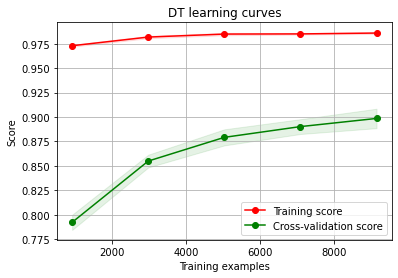

In [256]:
g = plot_learning_curve(grid_search.best_estimator_,"DT learning curves",train,y_train,cv=10)

- We can see that Decision Tree is unable to converge -> it needs more data 
- But we can conclude that it is not overfitting

We can use this tuned DT for futher analysis

# Train Using Different Features

In [341]:
def evaluate_with_features(f_data, features, class_label='class', skip_log=False):
    train, test, y_train, y_test = train_test_split(f_data[features], f_data[class_label], stratify=f_data[class_label])
    params = {'class_weight': 'balanced',
     'criterion': 'entropy',
     'max_depth': 20.0,
     'min_samples_leaf': 2,
     'random_state': 42}
    dt = tree.DecisionTreeClassifier(**params)
    dt.fit(train, y_train)
    train_pred = dt.predict(train)
    test_pred = dt.predict(test)

    frame1 = generate_all_stats(y_train,train_pred,y_test,test_pred)
    frame2 = generate_per_class_stats(y_train,train_pred,y_test,test_pred)

    return frame1, frame2,

In [259]:
raw_features = [
    'x', 'y', 'z'
]

f1, f2 = evaluate_with_features(final, raw_features)
f2

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.733198,0.871505,0.886926,0.958110,0.998198,1.000000
F1 (train),0.620332,0.811668,0.833777,0.937612,0.997298,1.000000
Prec (train),0.537579,0.759521,0.786637,0.917974,0.996400,1.000000
Recall (train),0.733198,0.871505,0.886926,0.958110,0.998198,1.000000
Acc (test),0.413688,0.559849,0.227513,0.274194,0.967568,0.825175
F1 (test),0.242116,0.401874,0.084337,0.118007,0.951619,0.746135
Prec (test),0.171138,0.313431,0.051762,0.075182,0.936187,0.680913
Recall (test),0.413688,0.559849,0.227513,0.274194,0.967568,0.825175


In [260]:
base_features = [
    'x', 'y', 'z', 
    'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean'
]

f1, f2 = evaluate_with_features(final, base_features)
f2

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.905402,0.939365,0.948763,0.980666,0.998198,0.997669
F1 (train),0.860451,0.909996,0.923818,0.971093,0.997298,0.996505
Prec (train),0.819753,0.882407,0.900152,0.961706,0.996400,0.995343
Recall (train),0.905402,0.939365,0.948763,0.980666,0.998198,0.997669
Acc (test),0.749049,0.781338,0.433862,0.403226,0.940541,0.825175
F1 (test),0.641577,0.685428,0.262559,0.231739,0.911722,0.746135
Prec (test),0.561075,0.610490,0.188237,0.162591,0.884617,0.680913
Recall (test),0.749049,0.781338,0.433862,0.403226,0.940541,0.825175


#### Just adding Features with last rolling mean improves the accuracy, precision of each class - but this seems to overift 

Now let's add some more features.

In [262]:
ext_features = [
    'x', 'y', 'z', 
    'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean',
    'rolling_x_std', 'rolling_y_std', 'rolling_z_std'
]

f1, f2 = evaluate_with_features(final, ext_features)
f2

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.967284,0.984920,0.963781,0.987111,0.998198,1.000000
F1 (train),0.951198,0.977437,0.946005,0.980708,0.997298,1.000000
Prec (train),0.935638,0.970067,0.928874,0.974387,0.996400,1.000000
Recall (train),0.967284,0.984920,0.963781,0.987111,0.998198,1.000000
Acc (test),0.922433,0.963242,0.735450,0.706452,0.962162,0.916084
F1 (test),0.885215,0.945207,0.623338,0.584926,0.943608,0.875963
Prec (test),0.850883,0.927836,0.540886,0.499074,0.925756,0.839210
Recall (test),0.922433,0.963242,0.735450,0.706452,0.962162,0.916084


#### The model is not overfitting much now except for DownStairs and Upstairs classes

In [264]:
ext_features2 = [
    'x', 'y', 'z', 
    'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean',
    'rolling_x_std', 'rolling_y_std', 'rolling_z_std',
    'rolling_x_min', 'rolling_y_min', 'rolling_z_min',
    'rolling_x_max', 'rolling_y_max', 'rolling_z_max'
]

f1, f2= evaluate_with_features(final, ext_features2)
f2

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.974892,0.988376,0.962898,0.989259,0.994595,1.000000
F1 (train),0.962498,0.982598,0.944697,0.983917,0.991899,1.000000
Prec (train),0.950415,0.976887,0.927172,0.978633,0.989218,1.000000
Recall (train),0.974892,0.988376,0.962898,0.989259,0.994595,1.000000
Acc (test),0.924715,0.965127,0.727513,0.683871,0.956757,0.951049
F1 (test),0.888545,0.948000,0.612760,0.555481,0.935613,0.927188
Prec (test),0.855098,0.931471,0.529275,0.467680,0.915383,0.904494
Recall (test),0.924715,0.965127,0.727513,0.683871,0.956757,0.951049


In [265]:

ext_features3 = [
    'x', 'y', 'z', 
    'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean',
    'rolling_x_std', 'rolling_y_std', 'rolling_z_std',
    'rolling_x_min', 'rolling_y_min', 'rolling_z_min',
    'rolling_x_max', 'rolling_y_max', 'rolling_z_max',
    'rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr'
]

f1, f2 = evaluate_with_features(final, ext_features3)
f2

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.970834,0.989632,0.964664,0.992481,0.989189,1.000000
F1 (train),0.956467,0.984476,0.947314,0.988736,0.983813,1.000000
Prec (train),0.942519,0.979372,0.930577,0.985019,0.978495,1.000000
Recall (train),0.970834,0.989632,0.964664,0.992481,0.989189,1.000000
Acc (test),0.928517,0.956645,0.611111,0.696774,0.935135,0.944056
F1 (test),0.894100,0.935447,0.463602,0.572256,0.903790,0.916889
Prec (test),0.862144,0.915169,0.373457,0.485494,0.874478,0.891242
Recall (test),0.928517,0.956645,0.611111,0.696774,0.935135,0.944056


In [266]:

ext_features4 = [
    'x', 'y', 'z', 
    'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean',
    'rolling_x_std', 'rolling_y_std', 'rolling_z_std',
    'rolling_x_min', 'rolling_y_min', 'rolling_z_min',
    'rolling_x_max', 'rolling_y_max', 'rolling_z_max',
    'rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr',
    'rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff'
]

f1, f2 = evaluate_with_features(final, ext_features4)
f2

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.973371,0.988690,0.976148,0.989259,1.000000,1.000000
F1 (train),0.960235,0.983067,0.964367,0.983917,1.000000,1.000000
Prec (train),0.947450,0.977508,0.952866,0.978633,1.000000,1.000000
Recall (train),0.973371,0.988690,0.976148,0.989259,1.000000,1.000000
Acc (test),0.921673,0.967012,0.719577,0.683871,0.951351,0.965035
F1 (test),0.884106,0.950795,0.602230,0.555481,0.927633,0.947864
Prec (test),0.849481,0.935113,0.517791,0.467680,0.905069,0.931292
Recall (test),0.921673,0.967012,0.719577,0.683871,0.951351,0.965035


In [267]:
ext_features5 = [
    'x', 'y', 'z', 
    'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean',
    'rolling_x_std', 'rolling_y_std', 'rolling_z_std',
    'rolling_x_min', 'rolling_y_min', 'rolling_z_min',
    'rolling_x_max', 'rolling_y_max', 'rolling_z_max',
    'rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr',
    'rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff',
    'rolling_x_r2', 'rolling_y_r2', 'rolling_z_r2'
]

f1, f2 = evaluate_with_features(final, ext_features5)

# Decision tree stats
f2

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.975146,0.989632,0.972615,0.990333,0.994595,1.000000
F1 (train),0.962875,0.984476,0.959112,0.985523,0.991899,1.000000
Prec (train),0.950909,0.979372,0.945980,0.980759,0.989218,1.000000
Recall (train),0.975146,0.989632,0.972615,0.990333,0.994595,1.000000
Acc (test),0.923954,0.957587,0.679894,0.661290,0.967568,0.937063
F1 (test),0.887434,0.936840,0.550340,0.526464,0.951619,0.906617
Prec (test),0.853692,0.916973,0.462256,0.437305,0.936187,0.878087
Recall (test),0.923954,0.957587,0.679894,0.661290,0.967568,0.937063


## Visualize Feature Impact

In [268]:
import random

featureDiffs = {
    'means': ['rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean'],
    'stdevs': ['rolling_x_std', 'rolling_y_std', 'rolling_z_std'],
    'min/max': [ 'rolling_x_min', 'rolling_y_min', 'rolling_z_min', 'rolling_x_max', 'rolling_y_max', 'rolling_z_max'],
    'iqr': ['rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr'],
    'absdiff': ['rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff'],
    'r^2': ['rolling_x_r2', 'rolling_y_r2', 'rolling_z_r2']
}

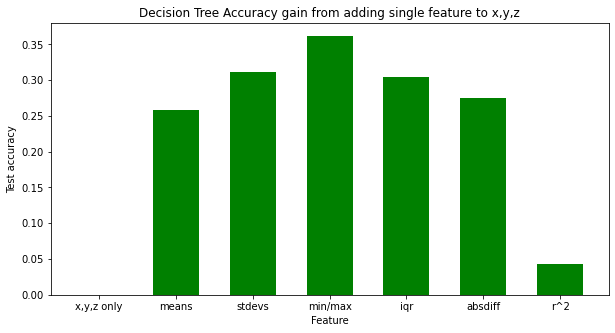

In [271]:
current_feats = list(raw_features)
base,_ = evaluate_with_features(final, current_feats)
data = { 'x,y,z only': 0 }

keys = featureDiffs.keys()
for label in keys:
    diff = featureDiffs[label]
    f1, _ = evaluate_with_features(final, current_feats + diff)
    data[label] = f1['test'][0] - base['test'][0]

courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
plt.bar(courses, values, color ='green', width = 0.6)
 
plt.xlabel("Feature")
plt.ylabel("Test accuracy")
plt.title("Decision Tree Accuracy gain from adding single feature to x,y,z")
plt.show()

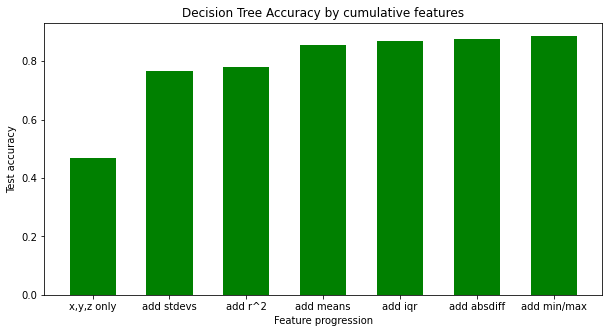

In [272]:
current_feats = list(raw_features)
f1, _, = evaluate_with_features(final, current_feats)
data = { 'x,y,z only': f1['test'][0] }

keys = list(featureDiffs.keys())
random.shuffle(keys)
for label in keys:
    diff = featureDiffs[label]
    current_feats += diff
    f1, f2 = evaluate_with_features(final, current_feats)
    data['add ' + label] = f1['test'][0]

courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='green',
        width = 0.6)
 
plt.xlabel("Feature progression")
plt.ylabel("Test accuracy")
plt.title("Decision Tree Accuracy by cumulative features")
plt.show()

<ipython-input-273-aeddc7ab4bbc>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)


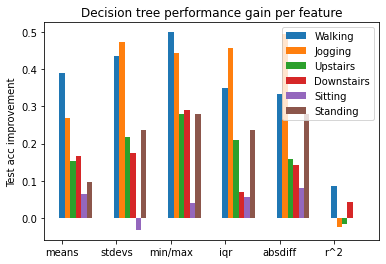

In [273]:
current_feats = list(raw_features)
_, base  = evaluate_with_features(final, current_feats)
data = { }

keys = featureDiffs.keys()
for label in keys:
    diff = featureDiffs[label]
    f1, f2  = evaluate_with_features(final, current_feats + diff)
    for c in f2:
        acc = f2[c][4]
        if not c in data:
            data[c] = {}
        data[c][label] = f2[c][5] - base[c][5]

fig, ax = plt.subplots()
x = np.arange(len(keys)) 
width = 0.1
for i, c in enumerate(data.keys()):
    rects = ax.bar(x + 6*width * i/len(list(data.keys())), data[c].values(), width, label=c)

labels = list(keys)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test acc improvement')
ax.set_title('Decision tree performance gain per feature')
ax.set_xticklabels([''] + labels)
ax.legend()

#fig.tight_layout()

plt.show()

In [274]:
# current_feats = list(raw_features)
# _, _, _, base = evaluate_with_features(final, current_feats)
# data = { }

# keys = featureDiffs.keys()
# for label in keys:
#     diff = featureDiffs[label]
#     f1, f2, f3, f4 = evaluate_with_features(final, current_feats + diff)
#     for c in f4:
#         acc = f4[c][4]
#         if not c in data:
#             data[c] = {}
#         data[c][label] = f4[c][5] - base[c][5]

# fig, ax = plt.subplots()
# x = np.arange(len(keys)) 
# width = 0.1
# for i, c in enumerate(data.keys()):
#     rects = ax.bar(x + 6*width * i/len(list(data.keys())), data[c].values(), width, label=c)

# labels = list(keys)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Test acc improvement')
# ax.set_title('Logistic regression performance gain per feature')
# ax.set_xticklabels([''] + labels)
# ax.legend()

# #fig.tight_layout()

# plt.show()

**Correlations** more importantly we check for Correlations between our features, 


As they are statistics calculated on the same data they are bound to have high correlations
In our final model we will not consifer features with correlations more than 0.85 (Industry Standard >0.7)

In [372]:
import seaborn as sns

In [378]:
data.columns

Index(['id', 'class', 'timestamp', 'x', 'y', 'z', 'class_mode',
       'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean', 'rolling_x_std',
       'rolling_y_std', 'rolling_z_std', 'rolling_x_min', 'rolling_y_min',
       'rolling_z_min', 'rolling_x_max', 'rolling_y_max', 'rolling_z_max',
       'rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr', 'avg_speed',
       'rolling_mean_speed', 'abs_x_diff', 'abs_y_diff', 'abs_z_diff',
       'rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff'],
      dtype='object')

<AxesSubplot:>

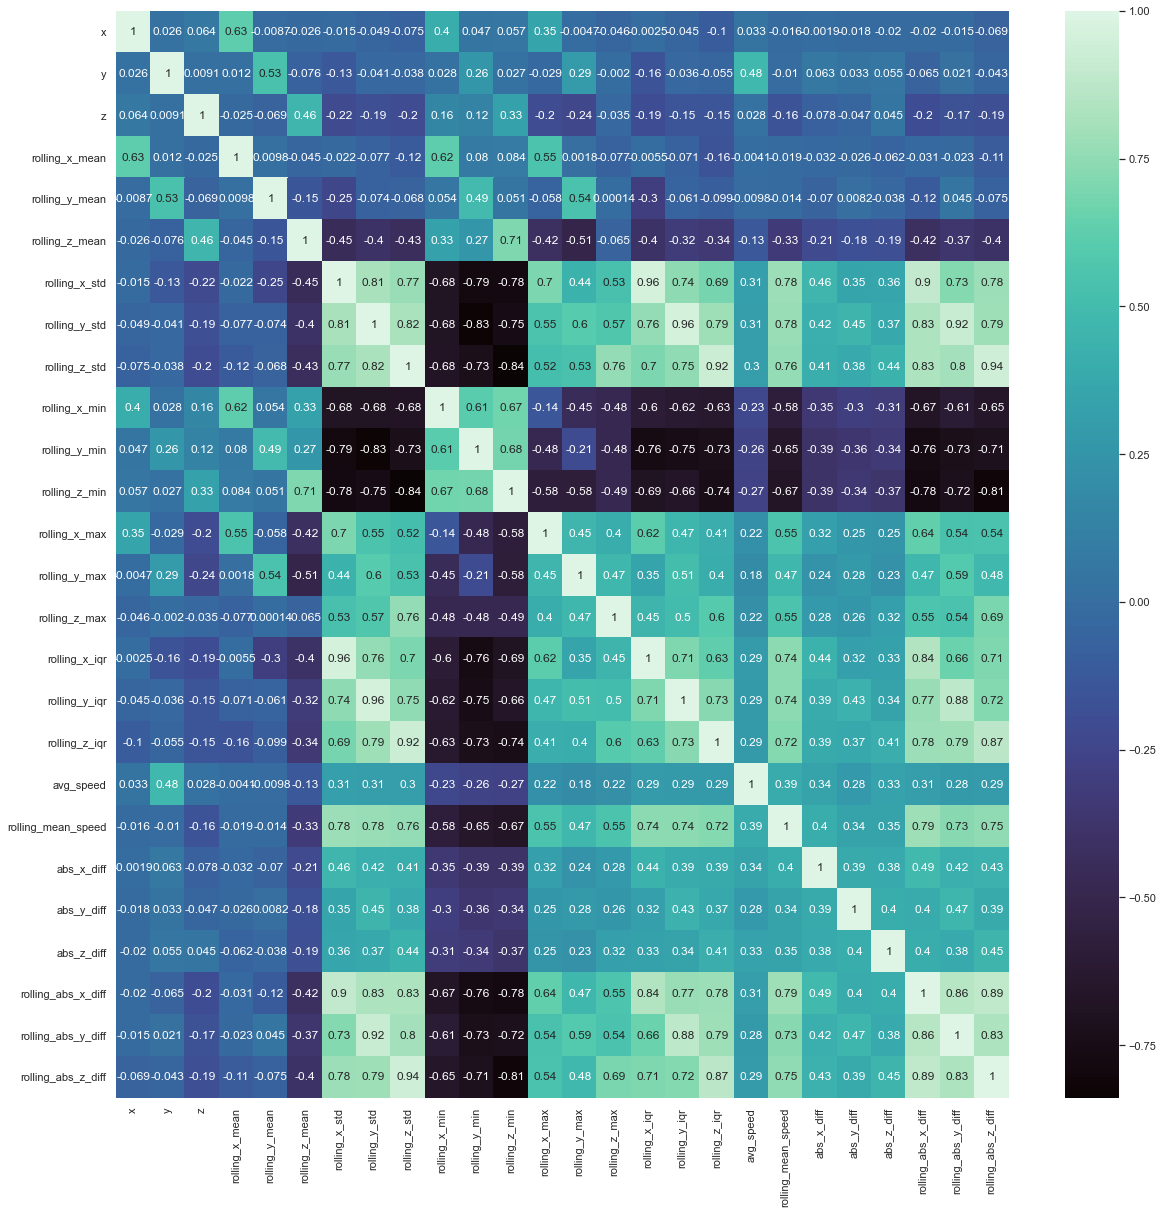

In [379]:
corr = data[[ 'x', 'y', 'z',
       'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean', 'rolling_x_std',
       'rolling_y_std', 'rolling_z_std', 'rolling_x_min', 'rolling_y_min',
       'rolling_z_min', 'rolling_x_max', 'rolling_y_max', 'rolling_z_max',
       'rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr', 'avg_speed',
       'rolling_mean_speed', 'abs_x_diff', 'abs_y_diff', 'abs_z_diff',
       'rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff']].corr()
sns.set(rc = {'figure.figsize':(20,20)})
sns.heatmap(corr, annot = True,
        xticklabels=True,
        yticklabels=True,cmap="mako")

In [534]:
threshold = 0.85
remove = []
cols = list(corr.columns)
visited = np.repeat(False, len(cols))
i = 0
while(True):
    visited[i]=True
    #If the correlation is more than threshold   
    if len(corr[cols[i]][np.abs(corr[cols[i]])>threshold])>1:
        for j in set(pd.DataFrame(corr[cols[i]][corr[cols[i]]>threshold]).index) - set([i]):
            visited[cols.index(j)]=True
            remove.append(j)
        #add to Remove list 
    if np.count_nonzero(visited==False) == 0 :
        break
    #check those columns which have not been previously checked
    i = np.where(visited==False)[0][0]
    

In [535]:
remove

['rolling_x_std',
 'rolling_x_iqr',
 'rolling_abs_x_diff',
 'rolling_y_std',
 'rolling_abs_y_diff',
 'rolling_y_iqr',
 'rolling_z_std',
 'rolling_z_iqr',
 'rolling_abs_z_diff']

### Quick Check: Does using modal class window help?

In [276]:
dt_stats, _ = evaluate_with_features(final, features, 'class')
dt_stats_mode, _ = evaluate_with_features(final, features, 'class_mode')

In [277]:
dt_stats

,train,test
Accuracy,0.983486,0.895047
F1,0.983370,0.894685
Precision,0.983578,0.894392
Recall,0.983486,0.895047


In [278]:
dt_stats_mode

,train,test
Accuracy,0.985845,0.900059
F1,0.985727,0.899178
Precision,0.985980,0.898889
Recall,0.985845,0.900059


It appears that using the modal activity per window didn't actually help much at
all, surprisingly.

Looks like the data - being emperically collected might have been monitored to have clear separations  

## Examine performance by rolling window parameters
Here, we change the parameters of our rolling-window preprocessing and measure
how it impacts performance.

In [319]:
# Minimum observations needed in a window for the data point to count.
min_periods = 5

slow_stride = 20
normal_stride = 2 * 20
fast_stride = 4 * 20

# Now let's create some sample rolling hyper parameters to search over.
hypers = [
    {'w': 100, 'stride': slow_stride },
    {'w': 100, 'stride': normal_stride },
    {'w': 100, 'stride': fast_stride },
    {'w': 200, 'stride': slow_stride },
    {'w': 200, 'stride': normal_stride },
    {'w': 200, 'stride': fast_stride },
    {'w': 300, 'stride': slow_stride },
    {'w': 300, 'stride': normal_stride },
    {'w': 300, 'stride': fast_stride },
    {'w': 400, 'stride': slow_stride },
    {'w': 400, 'stride': normal_stride },
    {'w': 400, 'stride': fast_stride }
]


In [320]:
ext_features4

['x',
 'y',
 'z',
 'rolling_x_mean',
 'rolling_y_mean',
 'rolling_z_mean',
 'rolling_x_std',
 'rolling_y_std',
 'rolling_z_std',
 'rolling_x_min',
 'rolling_y_min',
 'rolling_z_min',
 'rolling_x_max',
 'rolling_y_max',
 'rolling_z_max',
 'rolling_x_iqr',
 'rolling_y_iqr',
 'rolling_z_iqr',
 'rolling_abs_x_diff',
 'rolling_abs_y_diff',
 'rolling_abs_z_diff']

In [324]:
def try_window_strides(w,stride):
        # Reload our data fresh.
    data = pd.read_csv('./preProcessed_data.csv')
    data['classId'] = data['class'].map(classes.index) 

    class_window = data.groupby('id')['classId'].rolling(window=w, min_periods=5, center=False)
    data['class_mode_id'] = list(class_window.apply(statistics.mode, raw=True).fillna(0))
    data['class_mode'] = data['class_mode_id'].map(lambda x: classes[int(x)])
    #data.drop(columns=['classId', 'class_mode_id'], inplace=True)

    add_rolling_metrics(data, w, min_periods, False)
    subsampled = subsample_data(data, stride, w)
    stats, class_stats = evaluate_with_features(subsampled, ext_features4, class_label='class_mode')
    return stats, class_stats

In [321]:
perf_frames = []
for param in hypers:
    print(param)
    w = param['w']
    stride = param['stride']
    stats, class_stats = try_window_strides(w,stride)
    perf_frames.append((stats, class_stats))
    print(stats)

{'w': 100, 'stride': 20}
              train      test
Accuracy   0.989518  0.937253
F1         0.989464  0.937009
Precision  0.989595  0.936833
Recall     0.989518  0.937253
{'w': 100, 'stride': 40}
              train      test
Accuracy   0.987249  0.915445
F1         0.987178  0.914620
Precision  0.987352  0.914228
Recall     0.987249  0.915445
{'w': 100, 'stride': 80}
              train      test
Accuracy   0.983988  0.897481
F1         0.983828  0.896411
Precision  0.984201  0.895758
Recall     0.983988  0.897481
{'w': 200, 'stride': 20}
              train      test
Accuracy   0.993506  0.963253
F1         0.993481  0.962998
Precision  0.993534  0.962860
Recall     0.993506  0.963253
{'w': 200, 'stride': 40}
              train      test
Accuracy   0.988099  0.937306
F1         0.988018  0.936732
Precision  0.988170  0.936398
Recall     0.988099  0.937306
{'w': 200, 'stride': 80}
              train      test
Accuracy   0.986533  0.908608
F1         0.986425  0.909015
Precision 

<ipython-input-322-2e1cd7d6cc78>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)


(0.0, 1.0)

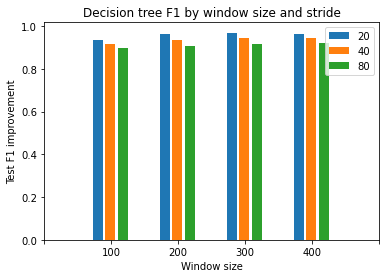

In [322]:
data = {}

for frames, param in zip(perf_frames, hypers):
    stats = frames[0]
    if param['stride'] not in data:
        data[param['stride']] = {}
    
    data[param['stride']][param['w']] = stats['test'][1]

fig, ax = plt.subplots()
width = 0.03
for i, c in enumerate(data.keys()):
    vals = list(data[c].values())
    size =len(vals)
    x = np.arange(size)/5 + 0.16
    rects = ax.bar(x + 5*width * i/size, vals, width, label=str(c))

labels = list(data[20].keys())

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test F1 improvement')
ax.set_xlabel('Window size')
ax.set_title('Decision tree F1 by window size and stride')
ax.set_xticklabels([''] + labels)
ax.legend()
ax.set_xlim(0, 1)

Works best near 300 

Trying more windows for precision

In [325]:
w = 260
stride = 20
stats, _ = try_window_strides(w,stride)
print('Window: ',w)
stats

Window:  260


,train,test
Accuracy,0.993999,0.964810
F1,0.993979,0.964671
Precision,0.994013,0.964567
Recall,0.993999,0.964810


In [326]:
w = 340
stride = 20
stats, _ = try_window_strides(w,stride)
print('Window: ',w)
stats

Window:  340


,train,test
Accuracy,0.989647,0.964621
F1,0.989557,0.964312
Precision,0.989678,0.964210
Recall,0.989647,0.964621


15 Seconds - 300 segment size with stride of 20 performs best

# Takeaways

## Data
The classes are highly imbalanced with walking/jogging being the two most
common. While the activities do seem to be well-separated, there are sometimes
long gaps between them.

The source paper doesn't go into much detail on handling accelerometer axis
orientation, so we ran PCA on the x,y,z data above. The results suggest that
the phones per user were not oriented in the same way -- however, training
our simple models on data projected onto standardized axes did not yield any
significant performance improvement, suggesting that, at least for the features
generated above, there is little impact on orientation itself.

## Features
All of the features generated above have a significant performance impact,
excluding perhaps R^2 (I'm surprised it's as low as it is).

_End of Section 2_

**___**



# Section 3

Training and Tuning Models based on the Features, Window size, Strides obtained above

In [328]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

import warnings
warnings.filterwarnings("ignore")

In [10]:
# Window Size 
w = 300

# Stride
stride = 20
min_periods = 5
center = False

In [11]:
# Creating data according to best recieved before 
data = pd.read_csv('./preProcessed_data.csv')
classes = list(data['class'].unique())
data['classId'] = data['class'].map(classes.index) 
class_window = data.groupby('id')['classId'].rolling(window=w, min_periods=5, center=False)
data['class_mode_id'] = list(class_window.apply(statistics.mode, raw=True).fillna(0))
data['class_mode'] = data['class_mode_id'].map(lambda x: classes[int(x)])
data.drop(columns=['classId', 'class_mode_id'], inplace=True)

In [23]:
add_rolling_metrics(data, w, min_periods, center)
subsampled = subsample_data(data, stride, w)
# stats, class_stats = evaluate_with_features(subsampled, ext_features4, class_label='class_mode')

In [24]:
data = subsampled
del(subsampled)

In [111]:
import sklearn 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold,cross_val_score
from sklearn.metrics import r2_score, recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix

In [26]:
data.class_mode.value_counts()

Walking       21013
Jogging       16929
Upstairs       6102
Downstairs     4746
Sitting        2901
Standing       2157
Name: class_mode, dtype: int64

In [27]:
data.columns

Index(['id', 'class', 'timestamp', 'x', 'y', 'z', 'class_mode',
       'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean', 'rolling_x_std',
       'rolling_y_std', 'rolling_z_std', 'rolling_x_min', 'rolling_y_min',
       'rolling_z_min', 'rolling_x_max', 'rolling_y_max', 'rolling_z_max',
       'rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr', 'avg_speed',
       'rolling_mean_speed', 'abs_x_diff', 'abs_y_diff', 'abs_z_diff',
       'rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff'],
      dtype='object')

In [28]:
features = [ 'x', 'y', 'z',
       'rolling_x_mean', 'rolling_y_mean', 'rolling_z_mean', 'rolling_x_std',
       'rolling_y_std', 'rolling_z_std', 'rolling_x_min', 'rolling_y_min',
       'rolling_z_min', 'rolling_x_max', 'rolling_y_max', 'rolling_z_max',
       'rolling_x_iqr', 'rolling_y_iqr', 'rolling_z_iqr', 'avg_speed',
       'rolling_mean_speed', 'abs_x_diff', 'abs_y_diff', 'abs_z_diff',
       'rolling_abs_x_diff', 'rolling_abs_y_diff', 'rolling_abs_z_diff']
#remove highly correlated
remove = ['rolling_x_std',
 'rolling_x_iqr',
 'rolling_abs_x_diff',
 'rolling_y_std',
 'rolling_abs_y_diff',
 'rolling_y_iqr',
 'rolling_z_std',
 'rolling_z_iqr',
 'rolling_abs_z_diff']

In [29]:
features = set(features) - set(remove)

In [30]:
X_train, X_test,y_train, y_test = train_test_split(data[features],data['class_mode'],stratify=data['class_mode'])

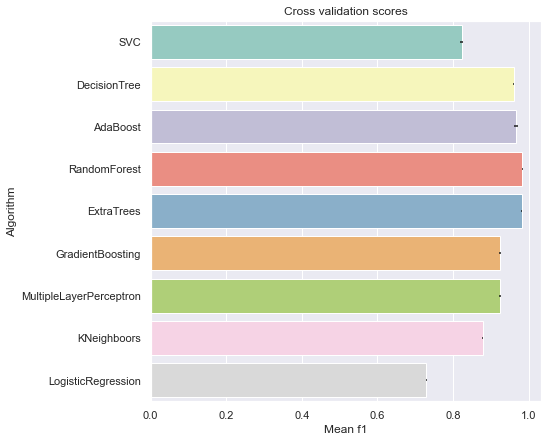

In [539]:
kfold = KFold(n_splits=5)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "f1_weighted", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression"]})

sns.set(rc = {'figure.figsize':(7,7)})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean f1")
g = g.set_title("Cross validation scores")

In [ ]:
# sorted(sklearn.metrics.SCORERS.keys())

We tuned Decision Trees already 


Tuning Random Forest and ExtraTrees as they seem to give best results 

In [49]:
len(features)

17

### Tuning Random forest

In [58]:
kfold = KFold(n_splits=5)
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": list(range(4,20,4)),
              "max_features": [3,7 ,10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True],
              "n_estimators" : list(range(200,1001,400)),
              "criterion": ["gini"]}

# gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1_weighted", n_jobs= -1, verbose = 1)


gsRFC = RandomizedSearchCV(RFC,param_distributions = rf_param_grid, cv=kfold, scoring="f1_weighted", n_jobs= -1, verbose = 1)



gsRFC.fit(X_train,y_train)

# Best score
gsRFC.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.9504326666949853

In [59]:
gsRFC.best_estimator_

RandomForestClassifier(max_depth=12, max_features=7, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=600)

In [132]:
gsRFC.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 7,
 'max_depth': 12,
 'criterion': 'gini',
 'bootstrap': True}

In [162]:
train_pred=gsRFC.best_estimator_.predict(X_train[features])
test_pred=gsRFC.best_estimator_.predict(X_test[features])

In [163]:
generate_all_stats(y_train,train_pred,y_test,test_pred)

,train,test
Accuracy,0.968479,0.953944
F1,0.968991,0.955073
Precision,0.970652,0.957955
Recall,0.968479,0.953944


In [164]:
generate_per_class_stats(y_train,train_pred,y_test,test_pred)

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.991117,0.995196,0.886364,0.866255,0.993107,0.962299
F1 (train),0.986695,0.992799,0.832968,0.804174,0.989672,0.943811
Prec (train),0.982312,0.990415,0.785640,0.750397,0.986261,0.926020
Recall (train),0.991117,0.995196,0.886364,0.866255,0.993107,0.962299
Acc (test),0.986103,0.993384,0.847313,0.791912,0.983448,0.949907
F1 (test),0.979203,0.990087,0.777280,0.699951,0.975241,0.925504
Prec (test),0.972399,0.986811,0.717940,0.627125,0.967171,0.902324
Recall (test),0.986103,0.993384,0.847313,0.791912,0.983448,0.949907


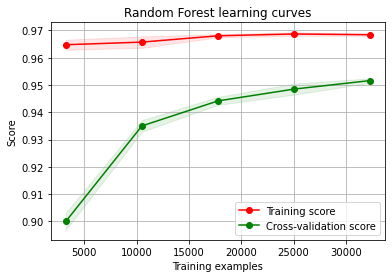

In [71]:
g = plot_learning_curve(gsRFC.best_estimator_,"Random Forest learning curves",X_train,y_train,cv=5)

<AxesSubplot:>

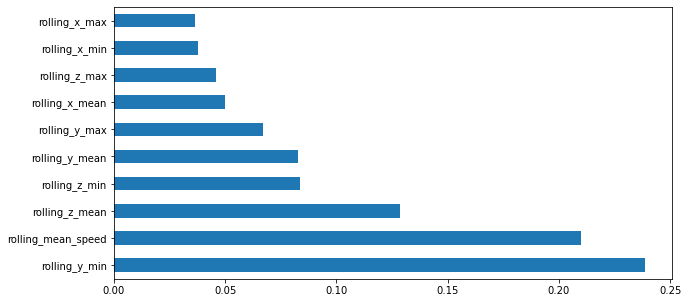

In [75]:
feat_imp = pd.Series(gsRFC.best_estimator_.feature_importances_, index=X_train.columns)
feat_imp.nlargest(10).plot(kind='barh', figsize=(10,5))

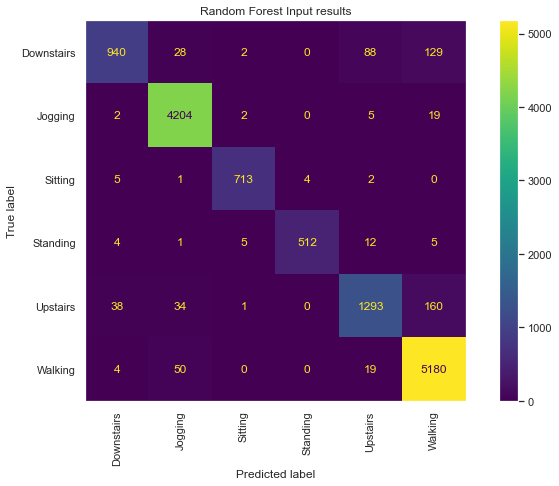

In [175]:
fig, ax1 = plt.subplots(figsize=(12, 7))
plot_confusion_matrix(gsRFC.best_estimator_,X_test,y_test,xticks_rotation='vertical',ax=ax1)
# normalize='true'
ax1.grid(False)
plt.title("Random Forest Input results")
plt.show()

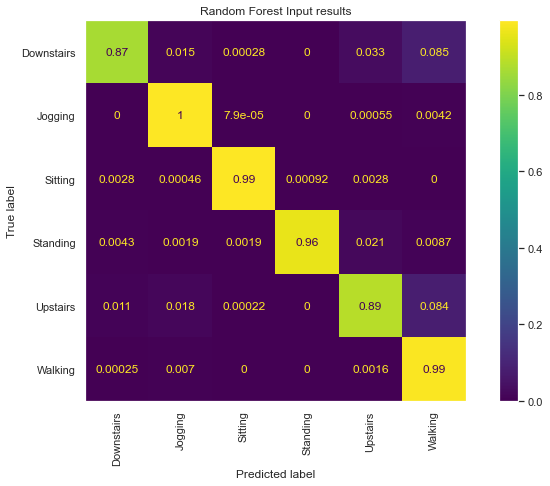

In [177]:
fig, ax1 = plt.subplots(figsize=(12, 7))
plot_confusion_matrix(gsRFC.best_estimator_,X_train,y_train,xticks_rotation='vertical',ax=ax1,normalize='true')
# 
ax1.grid(False)
plt.title("Random Forest Input results")
plt.show()

### Trying Random forest - with Standardised features 

In [118]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [123]:
std_X_train = scaler.transform(X_train)
std_X_test = scaler.transform(X_test)

In [125]:
clf = RandomForestClassifier(max_depth=12, max_features=7, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=600)
clf.fit(std_X_train,y_train)

RandomForestClassifier(max_depth=12, max_features=7, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=600)

In [168]:
train_pred=clf.predict(std_X_train)
test_pred=clf.predict(std_X_test)

In [127]:
generate_all_stats(y_train,train_pred,y_test,test_pred)

,train,test
Accuracy,0.969445,0.954464
F1,0.969922,0.955570
Precision,0.971439,0.958391
Recall,0.969445,0.954464


In [128]:
generate_per_class_stats(y_train,train_pred,y_test,test_pred)

,Walking,Jogging,Upstairs,Downstairs,Sitting,Standing
Acc (train),0.991434,0.995274,0.887675,0.873841,0.991728,0.964153
F1 (train),0.987169,0.992917,0.834854,0.815008,0.987609,0.946557
Prec (train),0.982941,0.990571,0.787967,0.763598,0.983524,0.929592
Recall (train),0.991434,0.995274,0.887675,0.873841,0.991728,0.964153
Acc (test),0.986484,0.993620,0.850590,0.792755,0.982069,0.948052
F1 (test),0.979772,0.990440,0.781916,0.701111,0.973185,0.922771
Prec (test),0.973151,0.987281,0.723503,0.628460,0.964459,0.898802
Recall (test),0.986484,0.993620,0.850590,0.792755,0.982069,0.948052


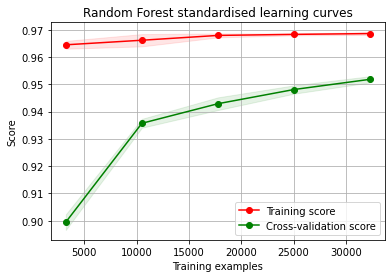

In [129]:
g = plot_learning_curve(clf,"Random Forest standardised learning curves",X_train,y_train,cv=5)

In [131]:
# feat_imp = pd.Series(clf.feature_importances_, index=X_train.columns)
# feat_imp.nlargest(10).plot(kind='barh', figsize=(10,5))

In [122]:
# X_test.drop(['class_mode','predict'],axis=1,inplace=True)

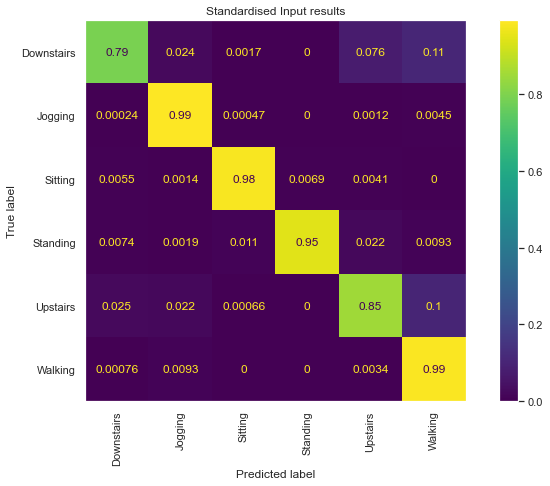

In [172]:
fig, ax1 = plt.subplots(figsize=(12, 7))
plot_confusion_matrix(clf,std_X_test,y_test,xticks_rotation='vertical',ax=ax1,normalize='true')
ax1.grid(False)
plt.title("Standardised Input results")
plt.show()

### Trying Random forest - with Smote class imbalance

### Visualise Decision Tree

In [184]:
dt = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3.0, min_samples_leaf=2, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3.0, min_samples_leaf=2, random_state=42)

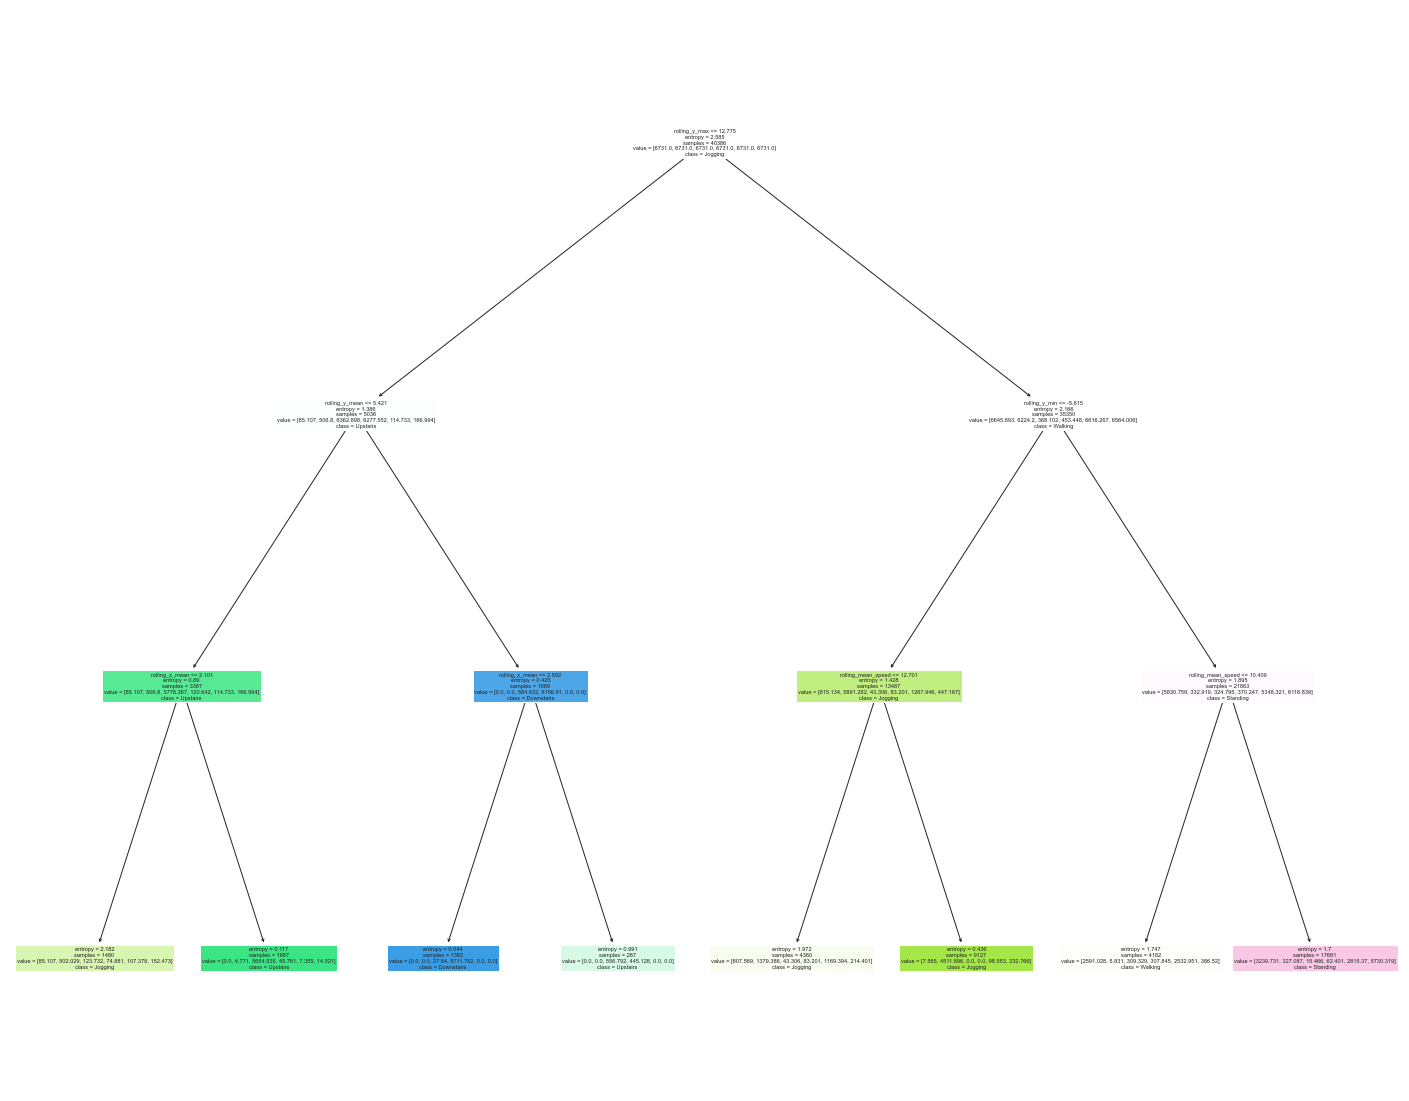

In [185]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt,
                   feature_names=X_train.columns,
                   class_names=list(y_train.unique()),
                   filled=True)
plt.savefig('/Users/smrutichourasia/Desktop/Study/CIS520 - ML/project/DT_rules.png')

### Tuning Extra Trees


# Analysis of results

In [90]:
X_test.reset_index(inplace=True,drop=True)

In [94]:
X_test['class_mode'] = list(y_test)
X_test['predict'] = list(test_pred)

In [102]:
X_test.loc[(np.where(y_test==test_pred)[0])][X_test['class_mode']=='Upstairs'].mean()

x                      0.591647
rolling_z_mean         0.356158
y                      7.879178
rolling_z_max         11.400440
rolling_y_mean         7.920209
z                      0.358211
rolling_mean_speed    10.641470
rolling_y_max         18.008969
rolling_z_min         -8.150626
rolling_y_min         -2.535533
abs_y_diff             2.775802
avg_speed             10.649857
rolling_x_max         10.090887
rolling_x_min         -8.607472
abs_z_diff             2.320217
rolling_x_mean         0.512686
abs_x_diff             2.495762
dtype: float64

In [95]:
X_test.loc[np.where(y_test!=test_pred)[0]]

,x,rolling_z_mean,y,rolling_z_max,rolling_y_mean,z,rolling_mean_speed,rolling_y_max,rolling_z_min,rolling_y_min,abs_y_diff,avg_speed,rolling_x_max,rolling_x_min,abs_z_diff,rolling_x_mean,abs_x_diff,class_mode,predict
0,-7.080000,-2.401067,-0.950000,12.640000,2.307567,-6.780000,9.977504,18.500000,-8.690000,-2.600000,0.130000,9.848721,2.410000,-13.670000,0.120000,-5.414333,0.080000,Sitting,Upstairs
7,-0.422231,2.308558,5.706926,13.061913,9.046680,0.953424,9.805612,19.381754,-2.833032,2.111154,3.445948,5.801405,2.451662,-6.319841,0.040861,-1.223153,3.595772,Downstairs,Upstairs
38,-4.060000,0.384633,8.620000,9.340000,9.165867,-0.500000,10.843547,18.350000,-10.690000,-1.610000,2.790000,9.541384,10.000000,-15.320000,1.530000,-2.326967,0.720000,Downstairs,Walking
41,8.240000,-0.341800,5.940000,13.530000,8.026067,-0.420000,11.357144,18.700000,-7.350000,0.110000,0.610000,10.166494,19.570000,-3.360000,0.460000,6.633033,1.040000,Upstairs,Walking
55,12.260000,-0.455267,2.260000,11.600000,6.580467,-2.300000,10.995350,19.270000,-9.530000,-5.750000,2.180000,12.676955,19.570000,-7.500000,1.300000,6.275833,7.890000,Downstairs,Upstairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13427,-2.760000,2.188034,16.320000,18.960000,8.619514,5.940000,11.920845,19.570000,-14.100000,-10.000000,3.340000,17.585323,12.150000,-13.211738,3.070000,-0.081557,5.290000,Upstairs,Jogging
13432,-1.610000,-1.028836,5.560000,10.501288,5.261300,6.701211,10.346177,18.350000,-13.947236,-0.650000,0.530000,8.855051,14.790000,-13.870000,0.967045,-2.436033,3.060000,Walking,Upstairs
13444,2.790000,0.619953,11.260000,14.137921,9.299767,5.856750,11.949970,18.810000,-8.240311,-2.070000,0.850000,12.995123,18.660000,-3.570000,12.326415,4.688033,0.120000,Downstairs,Walking
13452,-5.410000,-1.723433,6.740000,11.730000,10.353400,-7.820000,11.861205,19.570000,-15.470000,-0.890000,2.560000,11.655389,10.840000,-11.220000,2.920000,0.655733,1.580000,Upstairs,Walking


## Required functions 

In [68]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt